# *************CASE STUDY ON STACKOVERFLOW TAG PREDICTOR***************

## Introduction:

In this casestudy we will discusses how the tags are predicted to the asked question in the stackoverflow. Though their are more advanced algorithms to predicte the tags but using a simple linear algorithms like LogisticRegression and linearSVM we will predicte the tags because these both alogrithms are computationally less expensive.  

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.metrics import hamming_loss

In [2]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# STCAKOVERFLOW: TAG PREDTICTOR

# 1. Business Problem

#### Description

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.

Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.


#### Problem Statement

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

**Source**: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/

## 1.2 Real World / Business Objectives and Constraints

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

# 2. Machine Learning Problem

## 2.1 Data

### 2.1.1 Data Overview

All of the data is in 2 files: Train and Test.

Train.csv contains 4 columns: Id,Title,Body,Tags.

Test.csv contains the same columns but without the Tags, which you are to predict.

Size of Train.csv - 6.75GB

Size of Test.csv - 2GB

Number of rows in Train.csv = 6034195

The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).

#### Datafield Explaination

Dataset contains 6,034,195 rows. The columns in the table are:

Id - Unique identifier for each question

Title - The question's title

Body - The body of the question

Tags - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')


## 2.2 Mapping RealWorld Problem toMachine Learning Problem

### 2.2.1 Type of Machine learning Problem

It is a multi-label classification problem 

**Multi-label Classification:** Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. 

### 2.2.2 Performence Metric

**Micro-Averaged F1-Score (Mean F Score) :** The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 (precision recall) / (precision + recall)

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. 

**'Micro f1 score':** 
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance. 

**'Macro f1 score': **
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. 

https://www.kaggle.com/wiki/MeanFScore 
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html 


# 3. Explolatory Data Analysis

## 3.1 Data Loading and Cleaning

### 3.1.1 Using Pandas with SQLite to Load the data

In [0]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:11:06.348946


### 3.1.2 Counting the number of rows

In [0]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:01:27.498394


### 3.1.3 Checking for duplicates

In [0]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 2:34:21.578626


In [0]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [0]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [0]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [0]:
a = df_no_dup["Tags"]

b = a[0].split(" ")
#b = a.apply(lambda text: len(text.split(" ")))

In [0]:
print(len(b))

2


In [0]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(str(text).split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:06.677897


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [0]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: tag_count, dtype: int64

In [0]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [3]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:02:10.340639


## 3.2 Analysis of Tag

### 3.2.1 Total number of unique tags

In [0]:
tag_data.head()

,Tags
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
5,facebook api facebook-php-sdk


In [0]:
tag =[]

In [0]:
tag_data_vect = tag_data['Tags'].apply(lambda text: str(text).split())

In [0]:
print((tag_data_vect))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
import re
REGEX = re.compile(r",\s*")
def tokenize(text):
    return [tok.strip().lower() for tok in REGEX.split(text)]

In [0]:
tag = tag_data["Tags"]

In [0]:
print(tag)

1                                c# silverlight data-binding
2                        c# silverlight data-binding columns
3                                                   jsp jstl
4                                                  java jdbc
5                              facebook api facebook-php-sdk
6                                     javascript asp.net web
7                                                  php forms
8                               real-analysis measure-theory
9                                              hibernate hql
10                                  iphone email-integration
11                                       java servlets jboss
12                    android android-widget android-service
13                      c# .net rijndaelmanaged cryptostream
14                                        javascript listbox
15                                              sql subquery
16                                                    c feof
17                      

In [0]:
print(tag_data_vect[1])

['c#', 'silverlight', 'data-binding', 'columns']


In [0]:
tag = tag.values

c# silverlight data-binding


In [0]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split() )
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data["Tags"])

In [0]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42050


In [0]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### 3.2.3 Number of times a tag appeared

In [0]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [47]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [48]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

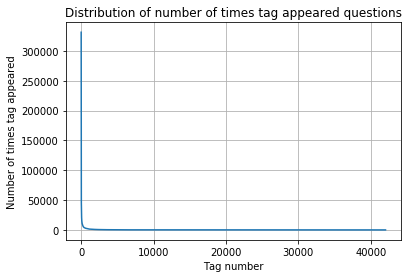

In [0]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

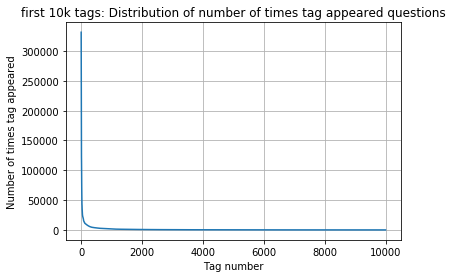

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2986   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [0]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

In [0]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

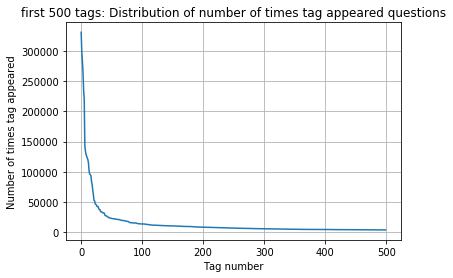

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3482]


In [0]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

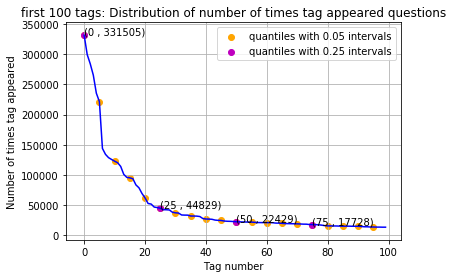

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [0]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [0]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


#### Observation:

    1.There are total 153 tags which are used more than 10000 times. 
    2.14 tags are used more than 100000 times.
    3.Most frequent tag (i.e. c#) is used 331505 times.                             
    4.Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.


### 3.2.4 Tags Per Question

In [0]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [0]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


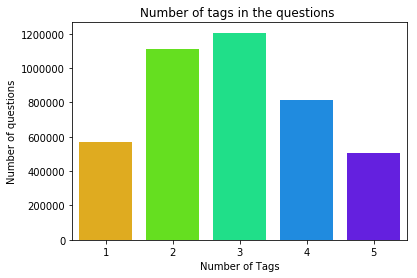

In [0]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

#### Observation:

### 3.2.5 Most Frequent Tags

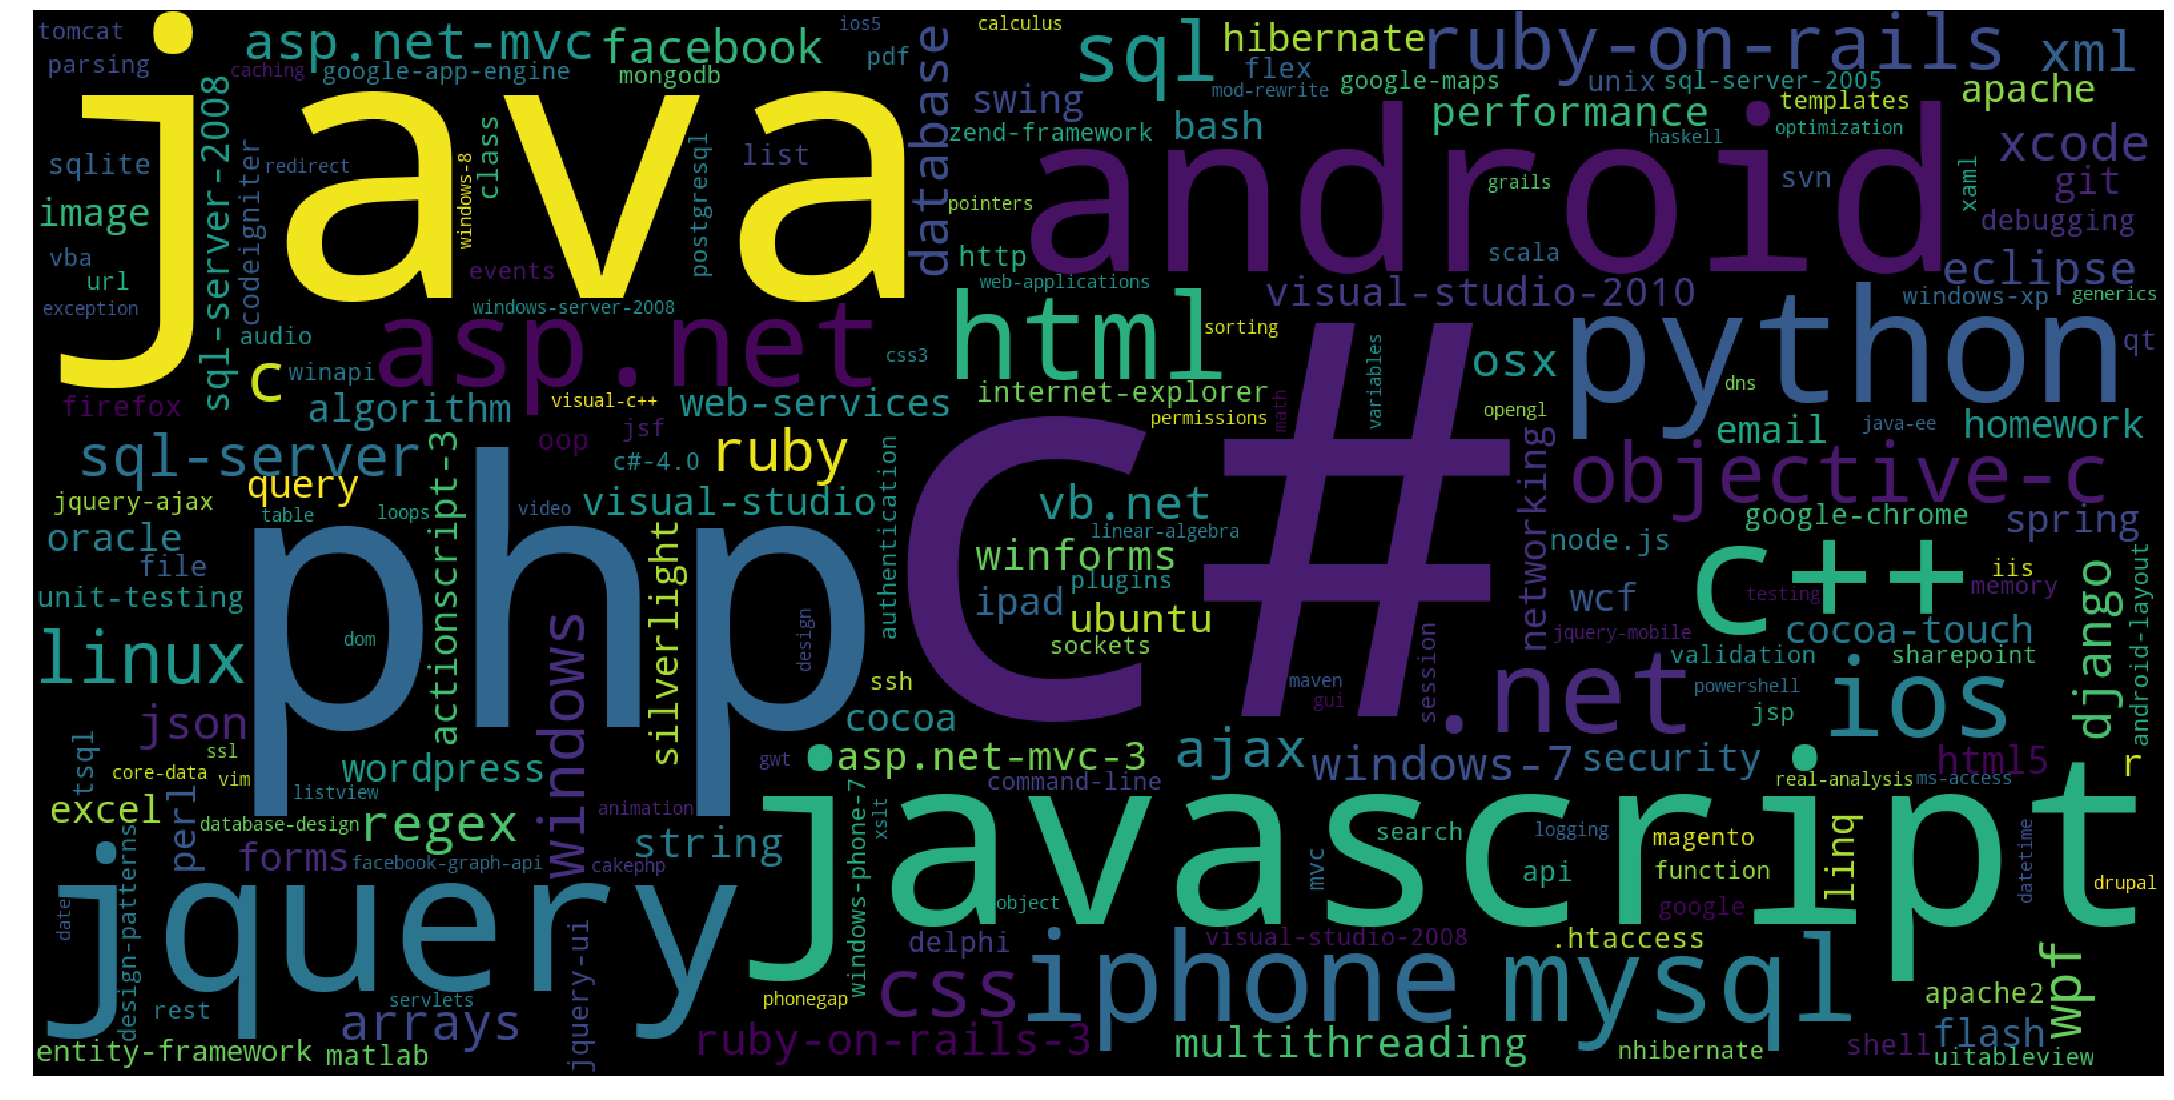

Time taken to run this cell : 0:00:22.725728


In [0]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

#### Observation:

A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

### 3.2.6 The top 20 tags

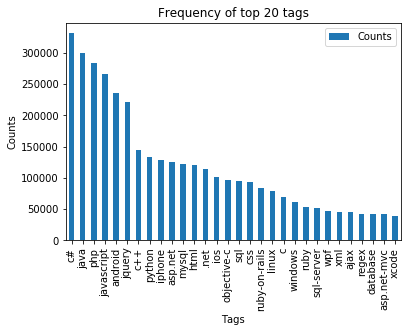

In [0]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

### Observations:

    1.Majority of the most frequent tags are programming language.
    2.C# is the top most frequent programming language.
    3.Android, IOS, Linux and windows are among the top most frequent operating systems.

In [ ]:
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Title FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

## 3.3 Title Analysis:

In [2]:
if os.path.isfile("train_no_dup.db"):
    con = sqlite3.connect("train_no_dup.db")
    title_data = pd.read_sql_query("SELECT Title FROM no_dup_train",con)
    con.close()

In [3]:
title_data_vect = title_data['Title'].apply(lambda text: str(text).split())

In [4]:
title_data_vect=pd.DataFrame(title_data_vect)

In [5]:
title_data_vect.shape

(4206315, 1)

In [6]:
len_of_title = title_data_vect["Title"].apply(lambda x: len(x))

In [7]:
len_of_title = pd.DataFrame(len_of_title)

In [8]:
len_of_title.columns = ["len_of_title"]

In [9]:
len_of_title.head()

,len_of_title
0,11
1,5
2,5
3,2
4,6


In [10]:
title_df_sorted = len_of_title.sort_values(['len_of_title'], ascending=False)
title_counts = title_df_sorted['len_of_title'].values

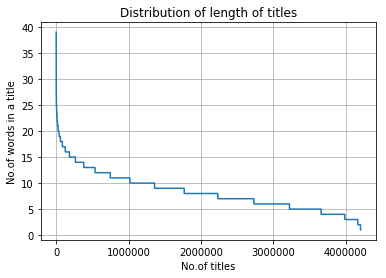

In [12]:
#for i in range(len(sizeoftitles)):
#plt.figure(figsize=(20,10))
#plt.subplot(1,2,1)
plt.plot(title_counts)
plt.title("Distribution of length of titles")
plt.xlabel("No.of titles")
plt.ylabel("No.of words in a title")
plt.grid()
plt.show()

In [14]:
print("the average length of titles:",title_counts.mean())

the average length of titles: 8.33400850863523


#### Observation:
- From the above analysis more two and half million titles contains 5-10 words.
- On average the length of titles are 8.
- So their is much possiblity that thier are much possibility that a title may explain tags, because mostly humans tend to explain the problem in one line. 

## 3.4 Modeling with less data points (0.5M data points) and more weight to title and 500 tags only.

### 3.4.1 Preprocessing

    1.Separate Code from Body
    2.Remove Spcial characters from Question title and description (not in code)
    3.Give more weightage to title : Add title three times to the question
    4.Remove stop words (Except 'C')
    5.Remove HTML Tags
    6.Convert all the characters into small letters
    7.Use SnowballStemmer to stem the words

In [0]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [6]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("TitleMoreWeighted.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'TitleMoreWeighted.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 1:55:41.168536


In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1168
Avg. length of questions(Title+Body) after processing: 408
Percent of questions containing code: 57
Time taken to run this cell : 1:49:29.786589


In [0]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

#### Sample quesitons after preprocessing of data

In [0]:
if os.path.isfile(write_db):
    print(".......")
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 5")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

.......
Questions after preprocessed
('android renderscript run gpu android renderscript run gpu android renderscript run gpu android devic renderscript execut gpu instead cpu someth yet implement anywher',)
----------------------------------------------------------------------------------------------------
('resiz uitableviewcel show imag maximum size resiz uitableviewcel show imag maximum size resiz uitableviewcel show imag maximum size want show imag text uitableview add imag uitableviewcel break layout overlap next header set size cell contain imag layout get broken found objc-cod suggest done use heightforrowatindexpath find anyth monotouch specif',)
----------------------------------------------------------------------------------------------------
('add radio button footer cell jqgrid add radio button footer cell jqgrid add radio button footer cell jqgrid new jqgrid would like use footer section grid column selector tri use radio button certain cell user select certain column gr

#### svaing preprocessed data into database

In [41]:
#Taking 0.5 Million entries to a dataframe.
start = datetime.now()
write_db = 'TitleMoreWeight.db'
if os.path.isfile('TitleMoreWeight.db'):
    conn_r = create_connection('TitleMoreWeighted.db')
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.012296


In [42]:
preprocessed_data.head()

,question,tags
0,correct method updat post content plugin corre...,plugins posts content
1,android renderscript run gpu android renderscr...,android renderscript
2,resiz uitableviewcel show imag maximum size re...,iphone monotouch
3,add radio button footer cell jqgrid add radio ...,jqgrid
4,filepath.walk panic filepath.walk panic filepa...,go


In [43]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


In [0]:
import pickle
with open("preprocessed_data.pkl","wb") as f:
    pickle.dump(preprocessed_data,f)

In [0]:
!ls

gdrive	sample_data


In [4]:
%cd ./gdrive

/content/gdrive


In [0]:
import pickle
#drive.mount('/content/drive')
DATA_PATH = "My Drive/stackoverflow_tag_predicte"
infile = open(DATA_PATH+"/preprocessed_data.pkl",'rb')
preprocessed_data = pickle.load(infile)

#### Converting string Tags to multilable output variables

In [44]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [52]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
#print("Some of the tags we have :", tags[-10:])

### 3.2.3 Number of times a tag appeared

# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = multilabel_y.sum(axis=0).A1
result = dict(zip(tags, freqs))

#### Selecting 500 Tags

In [28]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [31]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [32]:
print(questions_explained)

[90.057, 91.341, 92.094, 92.917, 93.659, 94.159, 94.573, 94.896, 95.234, 95.521, 95.799, 96.062, 96.338, 96.569, 96.759, 96.93, 97.091, 97.244, 97.367, 97.476, 97.592, 97.686, 97.784, 97.868, 97.941, 97.999, 98.073, 98.146, 98.226, 98.283, 98.341, 98.403, 98.457, 98.503, 98.551, 98.59, 98.63, 98.664, 98.713, 98.746, 98.78, 98.812, 98.841, 98.87, 98.893, 98.935, 98.959, 98.986, 99.007, 99.03, 99.049, 99.067, 99.089, 99.112, 99.131, 99.149, 99.164, 99.184, 99.201, 99.223, 99.237, 99.253, 99.273, 99.286, 99.304, 99.322, 99.337, 99.35, 99.365, 99.377, 99.388, 99.405, 99.415, 99.426, 99.438, 99.446, 99.455, 99.463, 99.472, 99.481, 99.494, 99.505, 99.513, 99.524, 99.531, 99.541, 99.55, 99.559, 99.57, 99.576, 99.582, 99.591, 99.596, 99.602, 99.608, 99.615, 99.621, 99.63, 99.638, 99.644, 99.652, 99.659, 99.667, 99.673, 99.681, 99.686, 99.693, 99.699, 99.702, 99.708, 99.713, 99.716, 99.72, 99.724, 99.727, 99.73, 99.732, 99.736, 99.739, 99.745, 99.748, 99.751, 99.754, 99.758, 99.761, 99.764, 99.

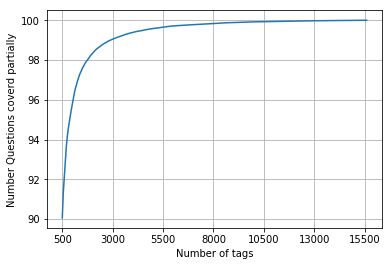

with  5500 tags we are covering  99.049 % of questions
with  500 tags we are covering  90.057 % of questions


In [34]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [10]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 49715 out of  500000


#### Analysing tags on 0.5M datapoints 

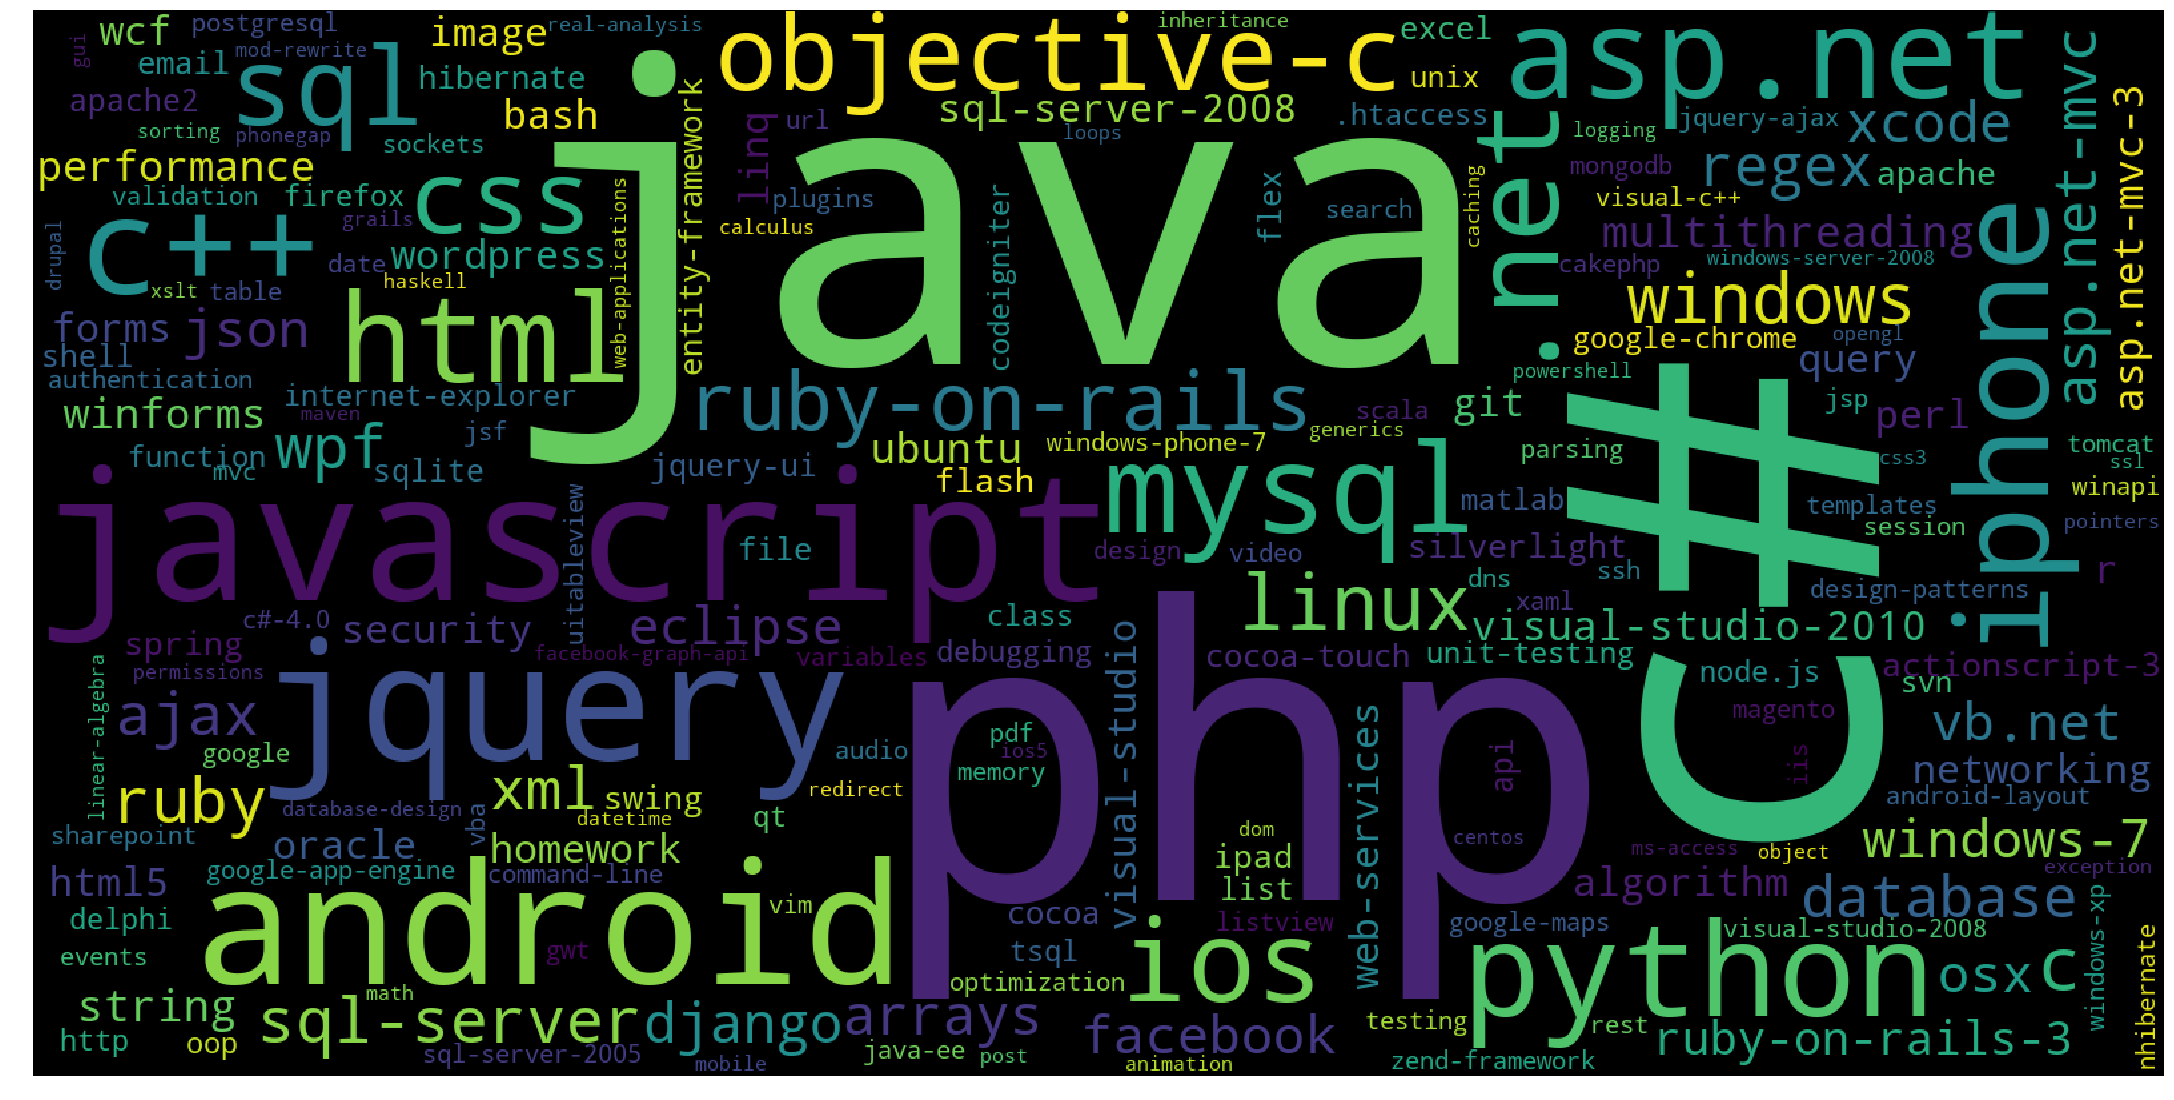

Time taken to run this cell : 0:00:09.145156


In [53]:
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

In [54]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

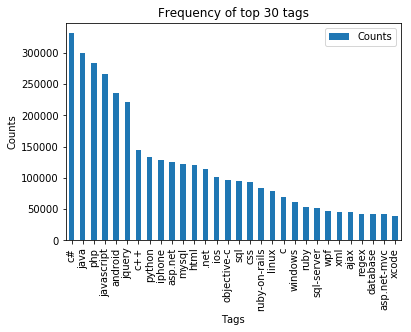

In [56]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

#### Observation:

In the sampled 0.5M datapoints their not much change in the tags count still C#,java, php, android,etc tags are the most frequently occuring tags 

In [0]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:preprocessed_data.shape[0],:]

In [12]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


## 3.5 Featurization

In [13]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, \
                             tokenizer = lambda x: x.split(), ngram_range=(1,3))#Here iam taking three grams due to insufficient memory
x_train_multilabel= vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:39.751953


In [14]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 87564) Y : (400000, 500)
Dimensions of test data X: (100000, 87564) Y: (100000, 500)


In [0]:
#start = datetime.now()
clf = SGDClassifier(loss='log', penalty='l2')
tuned_parameter ={'alpha': [10**-4, 10**-2, 10**1, 10**-2, 10**-4]}
#paramGrid = ParameterGrid(tuned_parameter)
model = OneVsRestClassifier(GridSearchCV(clf,  tuned_parameter, scoring = 'f1_micro', cv=3,n_jobs=-1))
model.fit(x_train_multilabel, y_train)
#print("the time taken to run this cell:",datetime.now() - start)

OneVsRestClassifier(estimator=GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter...re_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0),
          n_jobs=None)

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, loss='log',penalty='l2'),n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23656
Hamming loss  0.00283316
Micro-average quality numbers
Precision: 0.6895, Recall: 0.3906, F1-measure: 0.4987
Macro-average quality numbers
Precision: 0.5484, Recall: 0.3143, F1-measure: 0.3886
              precision    recall  f1-score   support

           0       0.58      0.37      0.45      7740
           1       0.83      0.41      0.55      7039
           2       0.84      0.55      0.67      6884
           3       0.74      0.42      0.54      6261
           4       0.94      0.76      0.84      5611
           5       0.86      0.65      0.74      5273
           6       0.81      0.51      0.63      3516
           7       0.85      0.63      0.72      3121
           8       0.68      0.43      0.53      3007
           9       0.75      0.45      0.56      2992
          10       0.83      0.62      0.71      2962
          11       0.55      0.19      0.28      2768
          12       0.46      0.17      0.25      2645
          13       0.64      0.

In [18]:
#start = datetime.now()
clf_svc = SGDClassifier(loss='hinge', penalty='l2')
tuned_parameter ={'alpha': [10**-4, 10**-2, 10**1, 10**-2, 10**-4]}
#paramGrid = ParameterGrid(tuned_parameter)
model_svc = OneVsRestClassifier(GridSearchCV(clf_svc,  tuned_parameter, scoring = 'f1_micro', cv=3,n_jobs=-1))
model_svc.fit(x_train_multilabel, y_train)
#print("the time taken to run this cell:",datetime.now() - start)

OneVsRestClassifier(estimator=GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_it...re_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0),
          n_jobs=None)

In [19]:
start = datetime.now()
classifier = OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, loss='hinge',penalty='l2'),n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23968
Hamming loss  0.00287584
Micro-average quality numbers
Precision: 0.6677, Recall: 0.4037, F1-measure: 0.5032
Macro-average quality numbers
Precision: 0.5431, Recall: 0.3200, F1-measure: 0.3863
              precision    recall  f1-score   support

           0       0.59      0.32      0.42      7740
           1       0.76      0.47      0.58      7039
           2       0.83      0.55      0.66      6884
           3       0.66      0.47      0.55      6261
           4       0.92      0.77      0.84      5611
           5       0.80      0.68      0.73      5273
           6       0.79      0.53      0.63      3516
           7       0.85      0.63      0.73      3121
           8       0.69      0.42      0.52      3007
           9       0.65      0.50      0.57      2992
          10       0.83      0.64      0.72      2962
          11       0.48      0.26      0.34      2768
          12       0.38      0.20      0.26      2645
          13       0.53      0.

# CONCLUSION:

Summary:

1. Load the data from train.csv to sqlite datadase.
2. Reomve the duplicate rows from the database and data is stored in train_no_dup.db.
3. check the most frequently, here their are 90% of tags are 500, So take only 500 tags.
4. sampled 0.5M data due to constrained resources.
4. Since the Stackoverflow is a website their can be html tags, So the next process is data cleaning. 
5. In this process allt he html tags are removed and SnowStemming is applied
6. Title is more important because the title is itself tells what is the question about. So, giving title more weight will be benificial that is why title itself is added three times.
7. After all the above process load the data into TitleMoreWeighted.db. 
8. preprocessed_data which is loaded into pickle file and uploaded into google drive.
5. checked if thier is any change in the tags. in my case their is no drastic change.
10.Finally, the data is splited into 70:30 ratio and BagOfWords Featurization is applied.
11.Then OneVsRestClassifier is used with SGDClassifier() with loss="log"and"hinge" which is basically logisticRegression and Linear_SVM and the results are compared. 

In [2]:
!pip install PrettyTable

  Using cached https://files.pythonhosted.org/packages/ef/30/4b0746848746ed5941f052479e7c23d2b56d174b82f4fd34a25e389831f5/prettytable-0.7.2.tar.bz2
  Running setup.py bdist_wheel for PrettyTable: started
  Running setup.py bdist_wheel for PrettyTable: finished with status 'done'
  Stored in directory: C:\Users\USER\AppData\Local\pip\Cache\wheels\80\34\1c\3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built PrettyTable


You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
from prettytable import PrettyTable

In [10]:
x= PrettyTable()

x.field_names = ["Algorithm","Accuracy","Hamming loss", "Micro_average-Precision,Recall,F1_measure","Macro_average-Precision,Recall,F1_measure","alpha"]

x.add_row(["Linear_SVM","0.23968","0.00287584","0.67, 0.40, 0.50","0.54, 0.32, 0.39","0.0001"])
x.add_row(["LogisticRegression"," 0.23656"," 0.00283316"," 0.69, 0.39, 0.50","0.55, 0.31, 0.39","0.0001"])

print(x)

+--------------------+----------+--------------+-------------------------------------------+-------------------------------------------+--------+
|     Algorithm      | Accuracy | Hamming loss | Micro_average-Precision,Recall,F1_measure | Macro_average-Precision,Recall,F1_measure | alpha  |
+--------------------+----------+--------------+-------------------------------------------+-------------------------------------------+--------+
|     Linear_SVM     | 0.23968  |  0.00287584  |              0.67, 0.40, 0.50             |              0.54, 0.32, 0.39             | 0.0001 |
| LogisticRegression |  0.23656 |  0.00283316  |              0.69, 0.39, 0.50             |              0.55, 0.31, 0.39             | 0.0001 |
+--------------------+----------+--------------+-------------------------------------------+-------------------------------------------+--------+


As we can see in the above table both the algorithms are performing very similar but performing LogisticRegression is computationally less expensive than linear_SVM.